In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm

%matplotlib inline 

In [4]:
diab = pd.read_csv("../data/diabetes.csv")
print("""
# Variables are
# subject: subject ID number
# age: age diagnosed with diabetes
# acidity: a measure of acidity called base deficit
# y: natural log of serum C-peptide concentration
# Original source is Sockett et al. (1987)
# mentioned in Hastie and Tibshirani's book 
# "Generalized Additive Models".
"""
)


# Variables are
# subject: subject ID number
# age: age diagnosed with diabetes
# acidity: a measure of acidity called base deficit
# y: natural log of serum C-peptide concentration
# Original source is Sockett et al. (1987)
# mentioned in Hastie and Tibshirani's book 
# "Generalized Additive Models".



In [5]:
xpred = pd.DataFrame({"age":np.arange(0,16.1,0.1)})

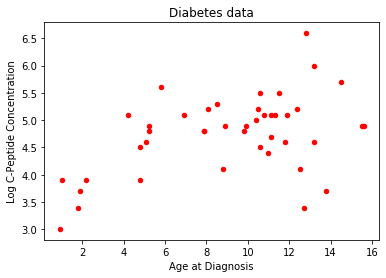

In [6]:
ax0 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data")
_ = ax0.set_xlabel("Age at Diagnosis")
_ = ax0.set_ylabel("Log C-Peptide Concentration")

## Linear Regression

In [7]:
model1 = sm.ols('y~age',data=diab)
fit1_lm = model1.fit()
pred1 = fit1_lm.predict(xpred)
prediction_output = fit1_lm.get_prediction(xpred).summary_frame()

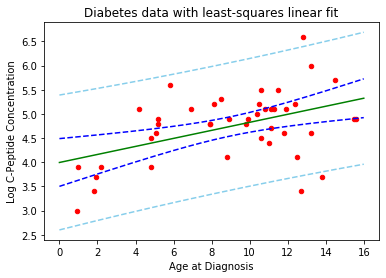

In [9]:
ax1 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares linear fit")
ax1.set_xlabel("Age at Diagnosis")
ax1.set_ylabel("Log C-Peptide Concentration")


ax1.plot(xpred.age, prediction_output['mean'],color="green")

ax1.plot(xpred.age, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(xpred.age, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

ax1.plot(xpred.age, prediction_output['obs_ci_lower'], color="skyblue",linestyle="dashed")
ax1.plot(xpred.age, prediction_output['obs_ci_upper'], color="skyblue",linestyle="dashed");

`vander` is for Vandermonde. It's a matrix where the first column is $x^0$, the second is $x^1$, the third is $x^2$ and so on.

` np.vander([6,3,5], 4, increasing=True) =                                 
                                            array([[  1,   6,  36, 216],  
                                                   [  1,   3,   9,  27],  
                                                   [  1,   5,  25, 125]])
`  
It's therefore similar to sklearn's `polynomial_features`, but because `vander` is numpy it can be used directly in the formula.

Since we have a constant column in the matrix, we put a -1 in the formula to drop the additional constant term statsmodels would otherwise insert

Note that this is **not** an _orthogonal_ polynomial basis. Our estimated coeffecients will be more sensitive to the data than they need to be.

In [10]:
fit2_lm = sm.ols(formula="y ~ np.vander(age, 4, increasing=True) -1",data=diab).fit()
fit2_lm = sm.ols(formula="y ~ age + np.power(age, 2) + np.power(age, 3)",data=diab).fit()

poly_predictions = fit2_lm.get_prediction(xpred).summary_frame()
poly_predictions.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.740481,0.508197,1.712556,3.768406,1.156238,4.324724
1,2.806326,0.486091,1.823115,3.789538,1.250724,4.361929
2,2.870902,0.464764,1.930827,3.810977,1.342198,4.399606
3,2.934219,0.444219,2.035702,3.832737,1.430714,4.437725
4,2.996291,0.424456,2.137747,3.854835,1.516327,4.476255


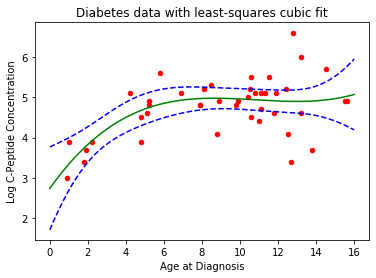

In [11]:
ax2 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
ax2.set_xlabel("Age at Diagnosis")
ax2.set_ylabel("Log C-Peptide Concentration")

ax2.plot(xpred.age, poly_predictions['mean'],color="green")
ax2.plot(xpred.age, poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(xpred.age, poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

#ax2.plot(xpred.age, poly_predictions['obs_ci_lower'], color="skyblue",linestyle="dashed")
#ax2.plot(xpred.age, poly_predictions['obs_ci_upper'], color="skyblue",linestyle="dashed");

## Logistic Regression

In [12]:
diab['y_bin'] = 1*(diab['y'] > 4) # multiply by 1 because statsmodels wants 1s and 0s instead of true and false

In [13]:
logit_model = sm.logit("y_bin ~ age ", data = diab).fit()
logit_prediction = logit_model.predict(xpred)

Optimization terminated successfully.
         Current function value: 0.353988
         Iterations 7


In [14]:
from scipy.special import expit
import re
def get_logit_prediction_intervals(model, new_data_df):
    if type(new_data_df) != pd.DataFrame:
        raise TypeError('new_data_df must be a DataFrame')
    
    # transform the raw data according to the formula
    new_data_dict = {}
    for x in model.params.index:
        # only presently supports Intercept, a named column, and polynmoials created via np.vander
        # the trick is finding the correct base column in the raw data
        if x == "Intercept":
            new_data_dict[x] = np.ones(new_data_df.shape[0])
        elif x.startswith("np.vander("):
            try:
                will = re.match(r"np.vander\((.*), ?(.*)\)\[(.*)\]", x)
                column, power, index = will.groups()
            except e:
                raise ValueError("Couldn't parse formula-derived feature {}".format(x))
            new_data_dict[x] = np.vander(new_data_df.loc[:,column], int(power))[:,int(index)]
        else:
            new_data_dict[x] = new_data_df.loc[:,x]
    new_data = pd.DataFrame(new_data_dict)
    
    variance_mat = model.cov_params()
    standard_devs = np.sqrt(np.sum(new_data.dot(variance_mat) * new_data, axis=1))
    
    linear_predictions = new_data.dot(model.params)
    output = pd.DataFrame({"lower": expit(linear_predictions - 1.96*standard_devs),
                  "predicted": expit(linear_predictions),
                  "upper": expit(linear_predictions + 1.96*standard_devs)
                 })
    return output

logit_prediction_intervals = get_logit_prediction_intervals(logit_model, xpred)
logit_prediction_intervals

,lower,predicted,upper
0,0.046716,0.230382,0.646460
1,0.049354,0.236818,0.649700
2,0.052128,0.243377,0.652945
3,0.055044,0.250058,0.656198
4,0.058108,0.256860,0.659458
...,...,...,...
156,0.867631,0.987899,0.999018
157,0.869055,0.988322,0.999074
158,0.870462,0.988729,0.999128
159,0.871853,0.989123,0.999178


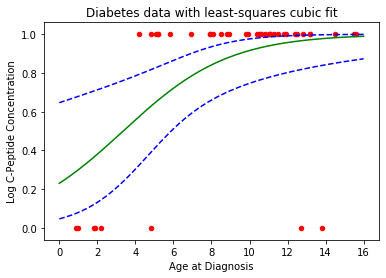

In [15]:
ax = diab.plot.scatter(x='age',y='y_bin',c='Red',title="Diabetes data with least-squares cubic fit")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration")

ax.plot(xpred.age, logit_prediction_intervals["predicted"],color="green")
ax.plot(xpred.age, logit_prediction_intervals["lower"], color="blue",linestyle="dashed")
ax.plot(xpred.age, logit_prediction_intervals["upper"], color="blue",linestyle="dashed");
plt.show()

In [16]:
logit_poly_model = sm.logit("y_bin ~ np.vander(age, 4) - 1", data = diab).fit()
logit_poly_prediction = logit_poly_model.predict(xpred)

Optimization terminated successfully.
         Current function value: 0.194005
         Iterations 10


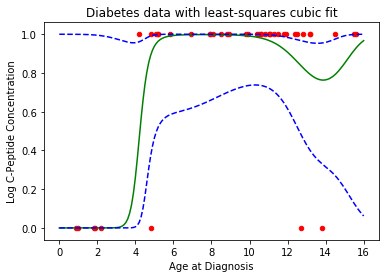

In [17]:
ax = diab.plot.scatter(x='age',y='y_bin',c='Red',title="Diabetes data with least-squares cubic fit")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration")

logit_poly_prediction_intervals = get_logit_prediction_intervals(logit_poly_model, xpred)

ax.plot(xpred.age, logit_poly_prediction_intervals["predicted"],color="green")
ax.plot(xpred.age, logit_poly_prediction_intervals["lower"], color="blue",linestyle="dashed")
ax.plot(xpred.age, logit_poly_prediction_intervals["upper"], color="blue",linestyle="dashed");
plt.show()

## Lo(w)ess

In [18]:
from statsmodels.nonparametric.smoothers_lowess import lowess as lowess

lowess_models = {}
for cur_frac in [.15,.25,.7, 1]:
    lowess_models[cur_frac] = lowess(diab['y'],diab['age'],frac=cur_frac)

**Note** Python's lowess implementation does not have any tool to predict on new data; it only returns the fitted function's value at the training points. We're making up for that by drawing a straight line between consecutive fitted values. (There are other more sophisticated interpolation techniques, but the ideal approach would be to predict on new points using lowess itself. This is a limitation of the Python implementation, not lowess itself)

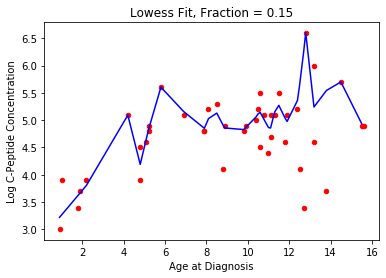

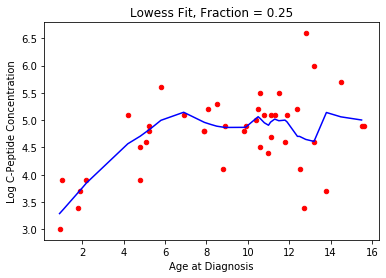

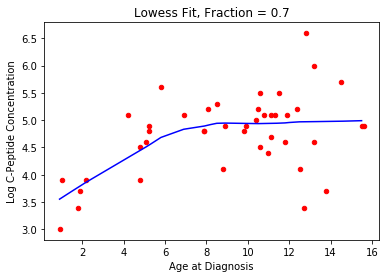

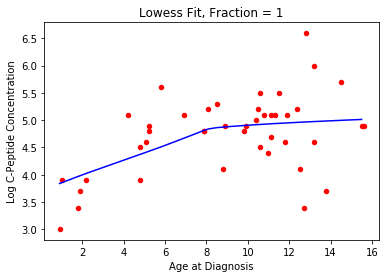

In [19]:
from scipy.interpolate import interp1d
for cur_frac, cur_model in lowess_models.items():
    ax = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = {}".format(cur_frac))
    ax.set_xlabel("Age at Diagnosis")
    ax.set_ylabel("Log C-Peptide Concentration")
    lowess_interpolation = interp1d(cur_model[:,0], cur_model[:,1], bounds_error=False)
    ax.plot(xpred, lowess_interpolation(xpred), color="Blue")
    plt.show()

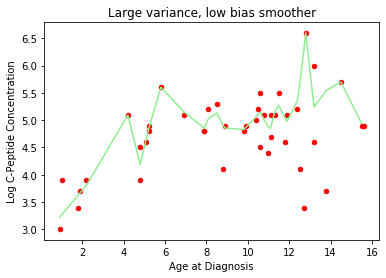

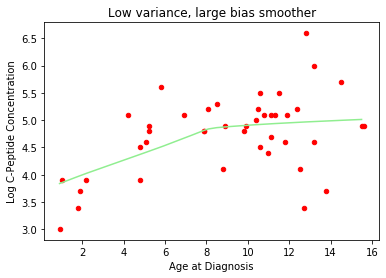

In [20]:
ax = diab.plot.scatter(x='age',y='y',c='Red',title="Large variance, low bias smoother")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration")
lowess_interpolation = interp1d(lowess_models[.15][:,0], lowess_models[.15][:,1], bounds_error=False)
ax.plot(xpred, lowess_interpolation(xpred), color="lightgreen")
plt.show()

ax = diab.plot.scatter(x='age',y='y',c='Red',title="Low variance, large bias smoother")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration")
lowess_interpolation = interp1d(lowess_models[1][:,0], lowess_models[1][:,1], bounds_error=False)
ax.plot(xpred, lowess_interpolation(xpred), color="lightgreen")
plt.show()

## Splines (via knots)

Define a Relu/Truncated cubic function

In [21]:
def h(x, knot, exponent):
    output = np.power(x-knot, exponent)
    output[x<=knot] = 0
    
    return output

Transforming the x values [0,10] with a knot at 4, power 1

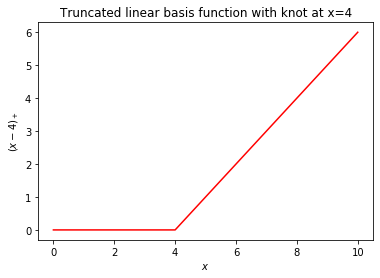

In [22]:
xvals = np.arange(0,10.1,0.1)

plt.plot(xvals, h(xvals,4,1), color="red")
plt.title("Truncated linear basis function with knot at x=4")
plt.xlabel("$x$")
plt.ylabel("$(x-4)_+$") #note the use of TeX in the label
plt.show()

Transforming the x values [0,10] with a knot at 4, power 3

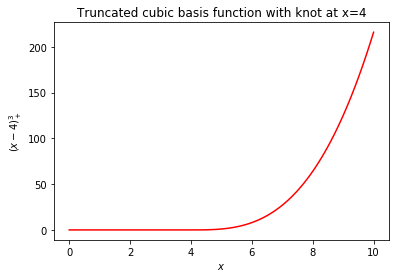

In [23]:
plt.plot(xvals,h(xvals,4,3),color="red")
plt.title("Truncated cubic basis function with knot at x=4")
plt.xlabel("$x$")
plt.ylabel("$(x-4)_+^3$")
plt.show()

The sum of three RELUs with different knots and different coeffecients

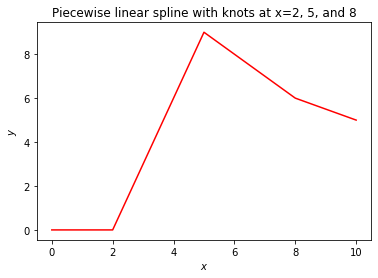

In [24]:
plt.plot(xvals, 3*h(xvals,2,1) - 4*h(xvals,5,1) + 0.5*h(xvals,8,1), color="red")
plt.title("Piecewise linear spline with knots at x=2, 5, and 8")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Above, but with a starting slope and intercept

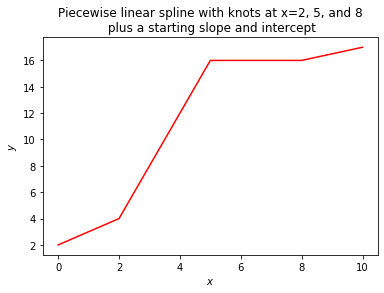

In [25]:
plt.plot(xvals, 2 + xvals + 3*h(xvals,2,1) - 4*h(xvals,5,1) + 0.5*h(xvals,8,1), color="red")
plt.title("Piecewise linear spline with knots at x=2, 5, and 8\n plus a starting slope and intercept")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Using OLS, we can find optimal coeffecients for RELUs with pre-specified knots, just like we can find optimal coeffecients for $x^2$ and $x^3$

In [26]:
# generate some fake data to fit

x = np.arange(0.1,10,9.9/100) 
from scipy.stats import norm
y = norm.ppf(x/10) + np.random.normal(0,0.4,100)

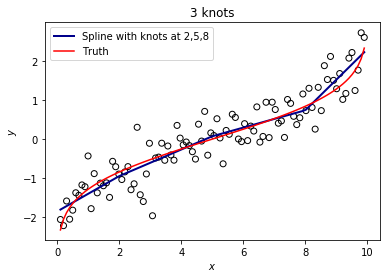

In [27]:
fitted_spline_model = sm.ols('y~x+h(x,2,1)+h(x,5,1)+h(x,8,1)',data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("3 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", linewidth=2, label="Spline with knots at 2,5,8")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

More knots

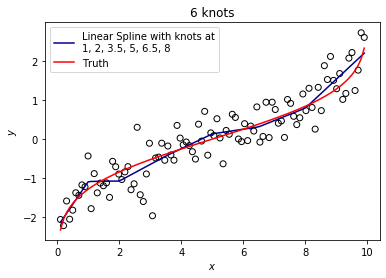

In [28]:
fitted_spline_model = sm.ols('y~x+h(x,1,1)+h(x,2,1)+h(x,3.5,1)+h(x,5,1)+h(x,6.5,1)+h(x,8,1)',data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("6 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Linear Spline with knots at\n1, 2, 3.5, 5, 6.5, 8")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

More knots

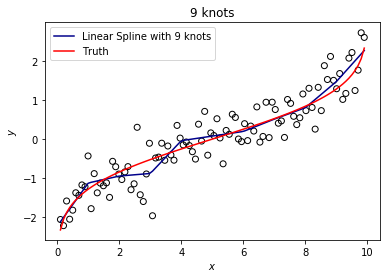

In [29]:
fitted_spline_model = sm.ols('y~x+h(x,1,1)+h(x,2,1)+h(x,3,1)+h(x,4,1)+h(x,5,1)+h(x,6,1)+h(x,7,1)+h(x,8,1)+h(x,9,1)',
                             data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("9 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Linear Spline with 9 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

Using code to write out the formula this time

In [30]:
n_knots = 25
components = ['h(x,{},1)'.format(x) for x in np.linspace(0,10,n_knots)]
formula = ' + '.join(components)
final_formula = 'y ~ x + ' + formula

final_formula

'y ~ x + h(x,0.0,1) + h(x,0.4166666666666667,1) + h(x,0.8333333333333334,1) + h(x,1.25,1) + h(x,1.6666666666666667,1) + h(x,2.0833333333333335,1) + h(x,2.5,1) + h(x,2.916666666666667,1) + h(x,3.3333333333333335,1) + h(x,3.75,1) + h(x,4.166666666666667,1) + h(x,4.583333333333334,1) + h(x,5.0,1) + h(x,5.416666666666667,1) + h(x,5.833333333333334,1) + h(x,6.25,1) + h(x,6.666666666666667,1) + h(x,7.083333333333334,1) + h(x,7.5,1) + h(x,7.916666666666667,1) + h(x,8.333333333333334,1) + h(x,8.75,1) + h(x,9.166666666666668,1) + h(x,9.583333333333334,1) + h(x,10.0,1)'

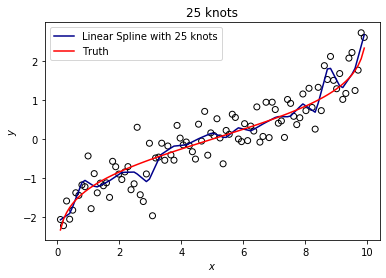

In [31]:
fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("25 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Linear Spline with 25 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

Cubic splines, instead of linear. Still using code to write the formula

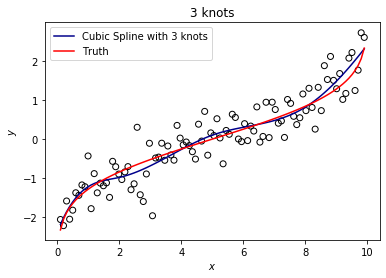

In [32]:
components = ['h(x,{},3)'.format(x) for x in [2,5,8]]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("3 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 3 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

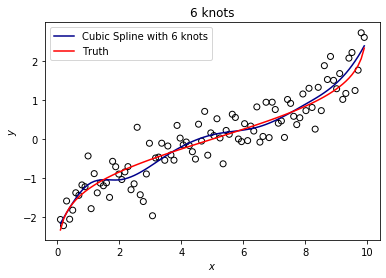

In [33]:
components = ['h(x,{},3)'.format(x) for x in [1,2,3.5,5,6.5,8]]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("6 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 6 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

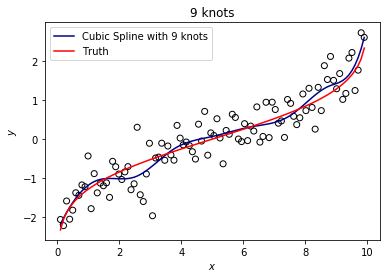

In [34]:
n_knots = 9
components = ['h(x,{},3)'.format(x) for x in np.linspace(0,10,n_knots)]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("9 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 9 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

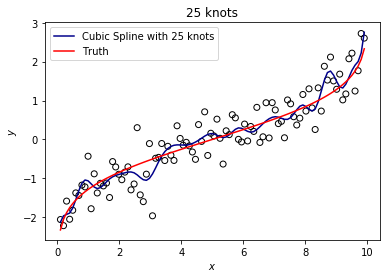

In [35]:
n_knots = 25
components = ['h(x,{},3)'.format(x) for x in np.linspace(0,10,n_knots)]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("25 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 25 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

## Smoothing splines

In [36]:
from scipy.interpolate import UnivariateSpline

This method won't allow tied values, and wants its values in sorted order. Add a tiny bit of noise to the x values and sort them.

In [37]:
diab['noisy_age'] = diab['age'] + np.random.normal(0,.001, len(diab))
sorted_noisy_diab = diab.sort_values(["noisy_age"])

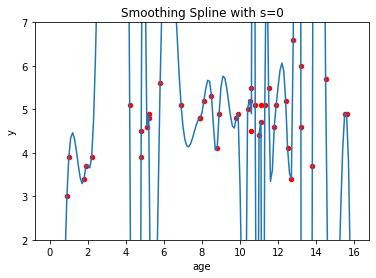

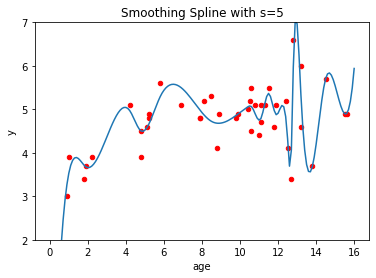

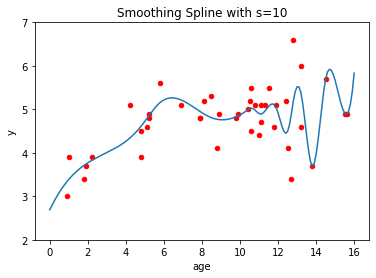

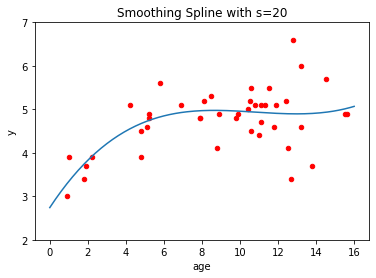

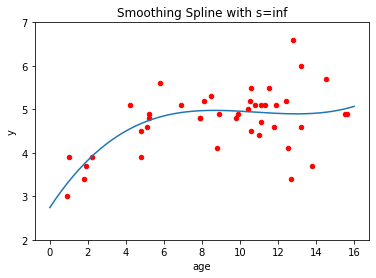

In [38]:
smoothing_spline_dict = {}
for cur_smoothing in [0, 5, 10, 20, np.inf]:
    
    cur_spline = UnivariateSpline(sorted_noisy_diab['noisy_age'],sorted_noisy_diab['y'], s=cur_smoothing)
    ax = diab.plot.scatter(x='age',y='y',c='Red',title="Smoothing Spline with s={}".format(cur_smoothing))
    ax.plot(xpred, cur_spline(xpred))
    # the jaggedness in the original came from plot's implicit linear interpolation
#     lowess_interpolation = interp1d(diab['age'], cur_spline(diab['age']), bounds_error=False)
#     ax.plot(xpred, lowess_interpolation(xpred), color="Blue")
    ax.set_ylim(2,7)

Even when we request infinite smoothness, we don't end up with a horizontal line (no derivatives at all)- we end up with a single cubic curve. That's because we chose a cubic spline.

In general, this implementation's smoothness regularization penalizes any derivatives _beyond_ what our basic spline needs. So with k=3, as above, the penalty is on the 4th derivative, and with k=2 the penalty is on the 3rd derivative and the "infinitely smooth" result will be a parabola. (i.e. a curve with 3rd derivative=0 everywhere)

Selecting smoothing level by CV

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

candidate_smoothings = [0, 5, 10, 20, 200]

kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,len(candidate_smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(sorted_noisy_diab)):
    train_df = sorted_noisy_diab.iloc[train_index,:]
    test_df = sorted_noisy_diab.iloc[test_index,:]
    for j,cur_smoothing in enumerate(candidate_smoothings):
        cur_model = UnivariateSpline(train_df['noisy_age'],train_df['y'], s=cur_smoothing)
        
        scores[i,j] = r2_score(test_df['y'], cur_model(test_df['noisy_age']))
        
np.mean(scores, axis=0)

array([-8.04693439e+02, -7.57243403e-01, -1.97142818e-01,  1.32779300e-01,
        1.32779300e-01])

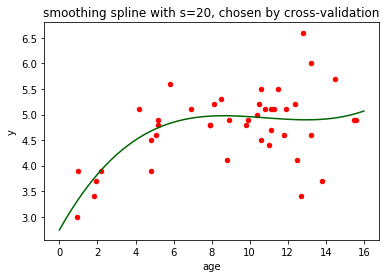

In [40]:
best_s = candidate_smoothings[np.argmax(np.mean(scores, axis=0))]

ax = diab.plot.scatter(x='age',y='y',c='Red',title="smoothing spline with s={}, chosen by cross-validation".format(best_s))
best_model = UnivariateSpline(sorted_noisy_diab['noisy_age'],sorted_noisy_diab['y'], s=best_s)
ax.plot(xpred, best_model(xpred), color="darkgreen")
plt.show()

In [41]:
#We will now work with a new dataset, called GAGurine.
#The dataset description (from the R package MASS) is below:
print("""
# Data were collected on the concentration of a chemical GAG 
# in the urine of 314 children aged from zero to seventeen years. 
# The aim of the study was to produce a chart to help a paediatrican
# to assess if a child's GAG concentration is ‘normal’.

# The variables are:
# Age: age of child in years.
# GAG: concentration of GAG (the units have been lost).
""")


# Data were collected on the concentration of a chemical GAG 
# in the urine of 314 children aged from zero to seventeen years. 
# The aim of the study was to produce a chart to help a paediatrican
# to assess if a child's GAG concentration is ‘normal’.

# The variables are:
# Age: age of child in years.
# GAG: concentration of GAG (the units have been lost).



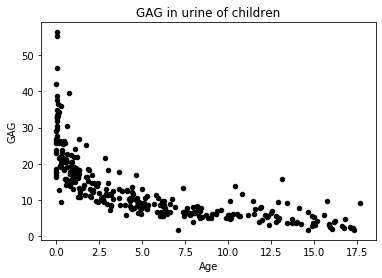

In [43]:
GAGurine = pd.read_csv("../data/GAGurine.csv")
GAGurine['Age'] = GAGurine['Age']+np.random.normal(0,0.001, len(GAGurine))
GAGurine = GAGurine.sort_values(['Age'])
ax = GAGurine.plot.scatter(x='Age',y='GAG',c='black',title="GAG in urine of children")
ax.set_xlabel("Age")
ax.set_ylabel("GAG")
plt.show()

Get quartiles

In [44]:
quarts = GAGurine['Age'].quantile([0.25, 0.5, 0.75]).values.reshape(-1)

Build a Bspline model. Call `splrep` (spline representation) to find the knots and coeffecients that smooth the given data, then call BSpline to build something that can predict on given values.

In [45]:
from scipy.interpolate import splrep
from scipy.interpolate import BSpline

t,c,k = splrep(GAGurine['Age'].values, GAGurine['GAG'].values, t=quarts)
b_spline_model = BSpline(t,c,k)
b_spline_model(7)

array(7.44392435)

`LSQUnivariateSpline` fits splines to data, using user-specified knots

In [46]:
from scipy.interpolate import LSQUnivariateSpline

natural_spline_model = LSQUnivariateSpline(GAGurine['Age'].values, GAGurine['GAG'].values, quarts)

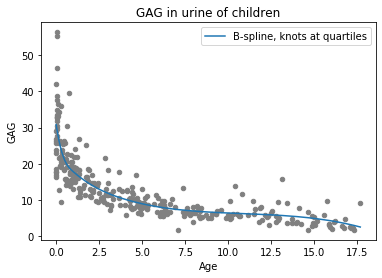

In [47]:
ax = GAGurine.plot.scatter(x='Age',y='GAG',c='grey',title="GAG in urine of children")
ax.plot(GAGurine['Age'], b_spline_model(GAGurine['Age']), label="B-spline, knots at quartiles")
plt.legend()
plt.show()

## GAMs

In [48]:
kyphosis = pd.read_csv("../data/kyphosis.csv")
kyphosis["outcome"] = 1*(kyphosis["Kyphosis"] == "present")
kyphosis.describe()

,Age,Number,Start,outcome
count,81.000000,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827,0.209877
std,58.104251,1.619423,4.883962,0.409758
min,1.000000,2.000000,1.000000,0.000000
25%,26.000000,3.000000,9.000000,0.000000
50%,87.000000,4.000000,13.000000,0.000000
75%,130.000000,5.000000,16.000000,0.000000
max,206.000000,10.000000,18.000000,1.000000


In [49]:
from pygam import LogisticGAM, s


X = kyphosis[["Age","Number","Start"]]
y = kyphosis["outcome"]
kyph_gam = LogisticGAM(s(0)+s(1)+s(2)).fit(X,y)

GAMs provide plots of the effect of increasing each variable (conditional on / adjusted for the other variables)

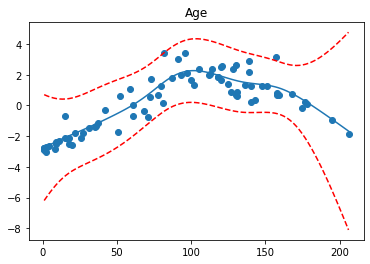

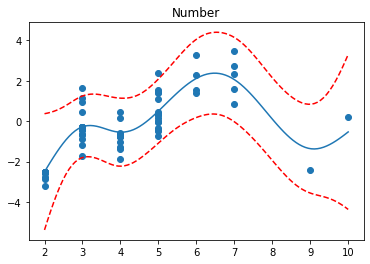

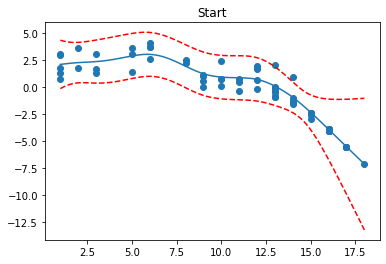

In [50]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

AIC is a measure of model quality, estimating performance on a test set (without actually needing a test set). It can be used to compare and select two models.

In [51]:
kyph_gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     14.2822
Link Function:                        LogitLink Log Likelihood:                                   -18.4906
Number of Samples:                           81 AIC:                                               65.5456
                                                AICc:                                              73.2352
                                                UBRE:                                               2.9503
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.5557
Feature Function                  Lam

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


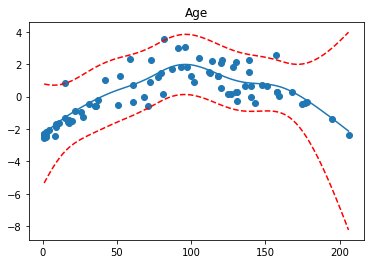

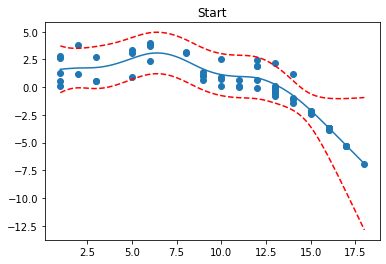

In [52]:
X = kyphosis[["Age","Number","Start"]]
y = kyphosis["outcome"]
small_kyph_gam = LogisticGAM(s(0)+s(2)).fit(X,y)


res = small_kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(small_kyph_gam.terms):
    if term.isintercept:
        continue

    XX = small_kyph_gam.generate_X_grid(term=i)
    pdep, confi = small_kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = small_kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

The original model's AIC was lower, so we prefer that model- it is expected to do better on out-of-sample data.

In [53]:
small_kyph_gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      10.478
Link Function:                        LogitLink Log Likelihood:                                   -23.3388
Number of Samples:                           81 AIC:                                               67.6337
                                                AICc:                                              71.8141
                                                UBRE:                                               2.9385
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4392
Feature Function                  Lam

/Users/wseaton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.
